In [62]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from pandas_profiling import ProfileReport
from pathlib import Path

# Import DataFrames

In [63]:
full_data = pd.read_csv("./datasets/application_record.csv")
credit_data = pd.read_csv("./datasets/credit_record.csv")

In [64]:
full_data

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


In [65]:
begin_month = pd.DataFrame(credit_data.groupby("MONTHS_BALANCE").agg(min))
begin_month = begin_month.rename(columns={'MONTHS_BALANCE':'Account age'})

credit_full_data = pd.merge(full_data, begin_month, how="left", on="ID")

credit_data["dep_value"] = None
credit_data['dep_value'][credit_data['STATUS'] =='2']='Yes'
credit_data['dep_value'][credit_data['STATUS'] =='3']='Yes'
credit_data['dep_value'][credit_data['STATUS'] =='4']='Yes'
credit_data['dep_value'][credit_data['STATUS'] =='5']='Yes' 
cpunt = credit_data.groupby('ID').count()
cpunt = cpunt[['dep_value']]
cpunt['dep_value'][cpunt['dep_value'] > 0] = 'Yes'
cpunt['dep_value'][cpunt['dep_value'] == 0] = 'No'
cpunt = cpunt[['dep_value']]

credit_full_data = pd.merge(credit_full_data, cpunt, how = 'inner', on = 'ID')
credit_full_data["Is high risk"] = credit_full_data['dep_value']    #Chỉ số đánh giá tín dụng

credit_full_data.loc[credit_full_data["Is high risk"] == 'Yes', 'Is high risk'] = 1
credit_full_data.loc[credit_full_data["Is high risk"] == 'No', 'Is high risk'] = 0
credit_full_data.drop('dep_value',axis=1,inplace= True)


C:\Users\Minh\AppData\Local\Temp\ipykernel_8656\2922295951.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_data['dep_value'][credit_data['STATUS'] =='2']='Yes'
C:\Users\Minh\AppData\Local\Temp\ipykernel_8656\2922295951.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_data['dep_value'][credit_data['STATUS'] =='3']='Yes'
C:\Users\Minh\AppData\Local\Temp\ipykernel_8656\2922295951.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

### Reaname featrures

In [66]:
credit_full_data = credit_full_data.rename(columns={
    'CODE_GENDER':'Gender',
    'FLAG_OWN_CAR':'Has a car',
    'FLAG_OWN_REALTY':'Has a property',
    'CNT_CHILDREN':'Children count',
    'AMT_INCOME_TOTAL':'Income',
    'NAME_INCOME_TYPE':'Employment status',
    'NAME_EDUCATION_TYPE':'Education level',
    'NAME_FAMILY_STATUS':'Marital status',
    'NAME_HOUSING_TYPE':'Dwelling',
    'DAYS_BIRTH':'Age',
    'DAYS_EMPLOYED': 'Employment length',
    'FLAG_MOBIL': 'Has a mobile phone',
    'FLAG_WORK_PHONE': 'Has a work phone',
    'FLAG_PHONE': 'Has a phone',
    'FLAG_EMAIL': 'Has an email',
    'OCCUPATION_TYPE': 'Job title',
    'CNT_FAM_MEMBERS': 'Family member count',
    'Account age': 'Account age'
})

In [67]:
credit_full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   Gender               36457 non-null  object 
 2   Has a car            36457 non-null  object 
 3   Has a property       36457 non-null  object 
 4   Children count       36457 non-null  int64  
 5   Income               36457 non-null  float64
 6   Employment status    36457 non-null  object 
 7   Education level      36457 non-null  object 
 8   Marital status       36457 non-null  object 
 9   Dwelling             36457 non-null  object 
 10  Age                  36457 non-null  int64  
 11  Employment length    36457 non-null  int64  
 12  Has a mobile phone   36457 non-null  int64  
 13  Has a work phone     36457 non-null  int64  
 14  Has a phone          36457 non-null  int64  
 15  Has an email         36457 non-null 

### Split data to training, testing and creating data

In [68]:
def data_split(df, testsize):
    train_df, test_df = train_test_split(df, test_size=testsize, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [69]:
train_original, test_original = data_split(credit_full_data, 0.2)

In [70]:
train_original.shape

(29165, 20)

In [71]:
test_original.shape

(7292, 20)

In [72]:
train_original.to_csv("train.csv", index= False)
test_original.to_csv("test.csv", index= False)

In [73]:
train_copy = train_original.copy()
test_copy = test_original.copy()

#### Exploxe the data
##### Data Profilting

In [99]:
profile_report = ProfileReport(train_copy, explorative=True, dark_mode=True)
profile_report_file_path = Path('./pandas_profile_file/credit_pred_profile.html')

try:
    profile_report_file_path.resolve(strict=True)
except FileNotFoundError:
    profile_report.to_file("./pandas_profile_file/credit_pred_profile.html")

Unexpected exception formatting exception. Falling back to standard exception


multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "d:\Anaconda\lib\multiprocessing\pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "d:\Anaconda\lib\multiprocessing\pool.py", line 48, in mapstar
    return list(map(*args))
  File "d:\Anaconda\lib\site-packages\pandas_profiling\describe.py", line 282, in multiprocess_func
    return x[0], describe_1d(x[1], **kwargs)
  File "d:\Anaconda\lib\site-packages\pandas_profiling\describe.py", line 270, in describe_1d
    result = result.append(describe_numeric_1d(data, **kwargs))
  File "d:\Anaconda\lib\site-packages\pandas_profiling\describe.py", line 54, in describe_numeric_1d
    stats['histogram'] = histogram(series, **kwargs)
  File "d:\Anaconda\lib\site-packages\pandas_profiling\plot.py", line 73, in histogram
    plot = _plot_histogram(series, **kwargs)
TypeError: _plot_histogram() got an unexpected keyword argument 'explorative'
"""

The above exception was the direct cause 

### 2. Funtction used each features

In [75]:
#Function trả về giá trị và tần số tương ứng của chúng
def value_count_norm_call(df, feature):
    frt_value_count = df[feature].value_counts()
    frt_value_count_norm = df[feature].value_counts(normalize=True) * 100
    frt_value_concat = pd.concat([frt_value_count, frt_value_count_norm], axis = 1)
    frt_value_concat.columns = ['Count', 'Frequency (%)']
    return frt_value_concat

In [76]:
def get_info(df, feature):
    if feature == 'Age':
            print('Description:\n{}'.format((np.abs(df[feature])/365).describe()))
            print('*'*50)
            print('Object type:{}'.format(df[feature].dtype))
    elif feature== 'Employment length':
           # chỉ chọn ra các người còn làm việc và bỏ qua những người đã nghỉ việc
            employment_len_no_ret = train_copy['Employment length'][train_copy['Employment length'] < 0]
            employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365
            print('Description:\n{}'.format((employment_len_no_ret_yrs).describe()))
            print('*'*50)
            print('Object type:{}'.format(employment_len_no_ret))
    elif feature =='Account age':
            # Thay đổi thời gian thành số dương
            print('Description:\n{}'.format((np.abs(df[feature])).describe()))
            print('*'*50)
            print('Object type:{}'.format(df[feature].dtype))
    else:
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            value_cnt = value_count_norm_call(df,feature)
            print('Value count:\n{}'.format(value_cnt))

In [77]:
# Function tạo biểu đồ hình tròn

def creat_pie_plot(df, feature):
    if feature == 'Drewlling' or 'Education level':
        ratio_size = value_count_norm_call(df, feature)
        ratio_size_len = len(ratio_size.index)
        ratio_list = []
        for i in range(ratio_size_len):
            ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
        fig, ax = plt.subplots(figsize=(8,8))
        # 1.2f %% hiển thị số thập phân trong biểu đồ hình tròn với 2 chữ số thập phân
        plt.pie(ratio_list, startangle=90, wedgeprops={'edgecolor' :'black'})
        plt.title('Pie chart of {}'.format(feature))
        plt.legend(loc='best',labels = ratio_size.index)
        plt.axis('equal')
        return plt.show()
    else :
        ratio_size = value_count_norm_call(df, feature)
        ratio_size_len = len(ratio_size.index)
        ratio_list = []
        for i in range(ratio_size_len):
            ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
        fig, ax = plt.subplots(figsize=(8,8))
        # 1.2f %% hiển thị số thập phân trong biểu đồ hình tròn với 2 chữ số thập phân
        plt.pie(ratio_list, labels = ratio_size.index, autopct='%1.2f%%', startangle=90, wedgeprops={'edgecolor' :'black'})
        plt.title('Pie chart of {}'.format(feature))
        plt.legend(loc='best')
        plt.axis('equal')
        return plt.show()

In [78]:
#function để tạo ra các bar chart
def creat_bar_chart(df, feature):
    if feature == 'Marital status' or 'Dwelling' or 'Job title'or 'Employment status' or 'Education level':
        fig, ax = plt.subplots(figsize=(6,10))
        sns.barplot(x=value_count_norm_call(df,feature).index,y=value_count_norm_call(df,feature).values[:,0])
        ax.set_xticklabels(labels=value_count_norm_call(df,feature).index,rotation=45,ha='right')
        plt.xlabel('{}'.format(feature))
        plt.ylabel('Count')
        plt.title('{} count'.format(feature))
        return plt.show()
    else:
        fig, ax = plt.subplots(figsize=(6,10))
        sns.barplot(x=value_count_norm_call(df,feature).index,y=value_count_norm_call(df,feature).values[:,0])
        plt.xlabel('{}'.format(feature))
        plt.ylabel('Count')
        plt.title('{} count'.format(feature))
        return plt.show()

In [79]:
#Function để tạo bar chart
def creat_bar_plot(df, feature):
    if feature == 'Marital status' or 'Dwelling' or 'Job title' or 'Employment status' or 'Education level':
        fig, ax = plt.subplots(figsize =(6, 10))
        sns.barplot(x = value_count_norm_call(df, feature).index, y = value_count_norm_call(df, feature).values[:, 0])
        ax.set_xticklabels(labels = value_count_norm_call(df, feature).index, rotation=45, ha= 'right')
        plt.xlabel('{}'.format(feature))
        plt.ylabel('Count')
        plt.title('{}count'.format(feature))
        return plt.show()
    else:
        fig, ax = plt.subplots(figsize=(6,10))
        sns.barplot(x=value_count_norm_call(df,feature).index,y=value_count_norm_call(df,feature).values[:,0])
        plt.xlabel('{}'.format(feature))
        plt.ylabel('Count')
        plt.title('{} count'.format(feature))
        return plt.show()

In [80]:
#Function tạo box plot
def creat_box_plot(df, feature):
    if feature == 'Age':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y = np.abs(df[feature]/365))
        plt.title('{} distribution(Boxplot)'.format(feature))
        return plt.show()
    elif feature == 'Children count':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=df[feature])
        plt.title('{} distribution(Boxplot)'.format(feature))
        plt.yticks(np.arange(0,df[feature].max(),1))
        return plt.show()
    elif feature == 'Employment length':
        fig, ax = plt.subplots(figsize=(2,8))
        employment_len_no_ret = train_copy['Employment length'][train_copy['Employment length'] < 0]
        employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
        sns.boxplot(y=employment_len_no_ret_yrs)
        plt.title('{} distribution(Boxplot)'.format(feature))
        plt.yticks(np.arange(0,employment_len_no_ret_yrs.max(),2))
        return plt.show()
    elif feature == 'Account age':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=np.abs(df[feature]))
        plt.title('{} distribution(Boxplot)'.format(feature))
        return plt.show()
    else:
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=df[feature])
        plt.title('{} distribution(Boxplot)'.format(feature))
        return plt.show()
        

In [81]:
def creat_hist_plot(df, feature, thebins=50):
    if feature == 'Age':
        fig, ax = plt.subplots(figsize= (18,10))
        sns.histplot(np.abs(df[feature]/365.25),bins= thebins)
        plt.title("{}distribution".format(feature))
        return plt.show()
    elif feature == 'Income':
        fig, ax = plt.subplots(figsize=(18, 10))
        sns.histplot(df[feature], bins= thebins)
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x),"," )))
        plt.title('{} distribution'.format(feature))
        return plt.show()
    elif feature == 'Account age':
        fig, ax = plt.subplots(18,10)
        sns.histplot(np.abs(df[feature], bins= thebins))
        plt.title("{}distribution".format(feature))
        return plt.show()
    else:
        fig, ax = plt.subplots(18,10)
        sns.histplot(df[feature], bins= thebins)
        plt.title("{}distribution".format(feature))
        return plt.show()

In [82]:
#Funcition tính độ rủi ro
def low_high_risk_bar_plot(df, feature):
    is_high_risk_grp = df.groupby(feature)['Is high risk'].sum()
    is_high_risk_srt = is_high_risk_grp.sort_values(ascending= True)
    print(is_high_risk_srt)
    fig, ax = plt.subplots(figsize=(6, 10))
    sns.barplot(x= is_high_risk_srt.index, y = is_high_risk_srt.values)
    ax.set_xticklabels(labels =  is_high_risk_srt.index)
    plt.ylabel('Count')
    plt.title("High risk appliacants count by high risk{}".format(feature))
    return plt.show()

# Phân tích đơn biến

## Gender

In [83]:
get_info(train_copy, "Gender")

Description:
count     29165
unique        2
top           F
freq      19549
Name: Gender, dtype: object
**************************************************
Object type:
object
Value count:
   Count  Frequency (%)
F  19549      67.028973
M   9616      32.971027


In [84]:
creat_bar_chart(train_copy, "Gender")

C:\Users\Minh\AppData\Local\Temp\ipykernel_8656\3069238624.py:10: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  return plt.show()


<li>Số nhân viên nam chiếm đa số với 19000 nhân viên</li>
<li> Số nhân viên nữ chiếm thiểu số với 9600 nhân viên </li>

In [85]:
creat_pie_plot(train_copy, 'Gender')

C:\Users\Minh\AppData\Local\Temp\ipykernel_8656\1976869441.py:16: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  return plt.show()


<li>Nhân viên nam chiếm đa số với 63% </li>
<li>Nhân viên nữ chiếm thiểu số với 37% </li>

## Age

In [86]:
get_info(train_copy, 'Age')

Description:
count    29165.000000
mean        43.779390
std         11.515062
min         21.109589
25%         34.178082
50%         42.643836
75%         53.271233
max         68.909589
Name: Age, dtype: float64
**************************************************
Object type:int64


In [87]:
creat_box_plot(train_copy, 'Age')

C:\Users\Minh\AppData\Local\Temp\ipykernel_8656\1430757122.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  return plt.show()


In [88]:
creat_hist_plot(train_copy, 'Age')

C:\Users\Minh\AppData\Local\Temp\ipykernel_8656\3869348336.py:6: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  return plt.show()


<li>Độ tuổi phổ biến của công ty là khoảng 28-42 tuổi</li>

#### Marital status

In [89]:
get_info(train_copy, 'Marital status')

Description:
count       29165
unique          5
top       Married
freq        20044
Name: Marital status, dtype: object
**************************************************
Object type:
object
Value count:
                      Count  Frequency (%)
Married               20044      68.726213
Single / not married   3864      13.248757
Civil marriage         2312       7.927310
Separated              1712       5.870050
Widow                  1233       4.227670


In [90]:
creat_pie_plot(train_copy, 'Marital status')

C:\Users\Minh\AppData\Local\Temp\ipykernel_8656\1976869441.py:16: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  return plt.show()


<li>Tình trạng hôn nhân chủ yếu công ty là Đã kết hôn chiếm tỉ trọng 68%</li>
<li>Tình trạng hôn nhân phổ biến thứ hai của công ty là độc thân/ chưa kết hôn chiếm tỉ trọng 13% </li>

In [91]:
creat_bar_chart(train_copy, 'Marital status')

C:\Users\Minh\AppData\Local\Temp\ipykernel_8656\3069238624.py:10: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  return plt.show()


### Family member count

In [92]:
get_info(train_copy, 'Family member count')

Description:
count    29165.000000
mean         2.197531
std          0.912189
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         20.000000
Name: Family member count, dtype: float64
**************************************************
Object type:
float64
Value count:
      Count  Frequency (%)
2.0   15552      53.324190
1.0    5613      19.245671
3.0    5121      17.558718
4.0    2503       8.582205
5.0     309       1.059489
6.0      48       0.164581
7.0      14       0.048003
9.0       2       0.006858
15.0      2       0.006858
20.0      1       0.003429


In [93]:
creat_box_plot(train_copy, 'Marital status')

TypeError: Vertical orientation requires numeric `y` variable.

Marital status
Civil marriage            89
Widow                    121
Separated                129
Single / not married     413
Married                 1561
Name: Is high risk, dtype: int64


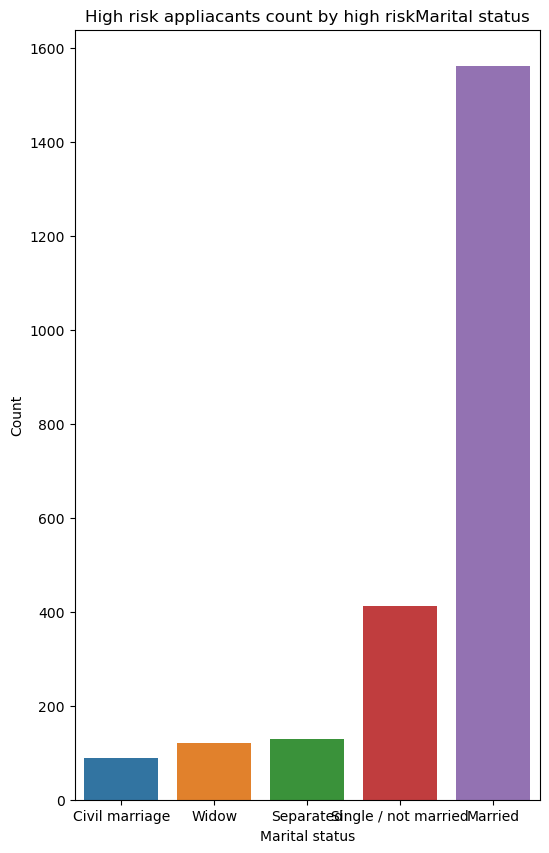

In [ ]:
low_high_risk_bar_plot(train_copy, 'Marital status')

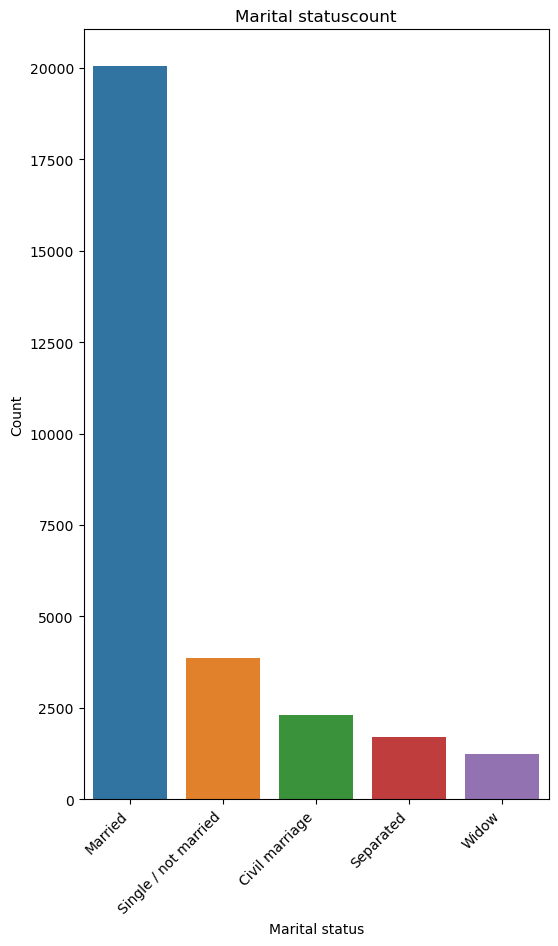

In [ ]:
creat_bar_plot(train_copy, 'Marital status')

### Childern count

In [ ]:
get_info(train_copy, 'Children count')

Description:
count    29165.000000
mean         0.430790
std          0.741882
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         19.000000
Name: Children count, dtype: float64
**************************************************
Object type:
int64
Value count:
    Count  Frequency (%)
0   20143       0.690657
1    6003       0.205829
2    2624       0.089971
3     323       0.011075
4      52       0.001783
5      15       0.000514
7       2       0.000069
14      2       0.000069
19      1       0.000034


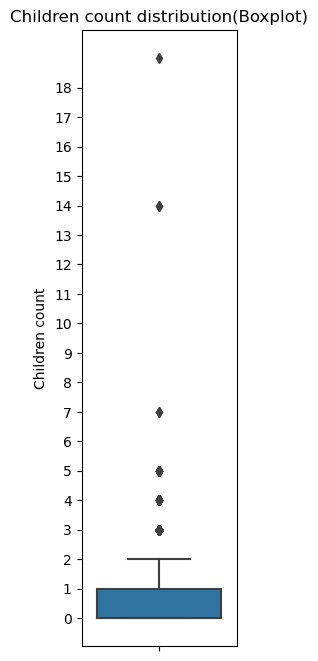

In [ ]:
creat_box_plot(train_copy, 'Children count')

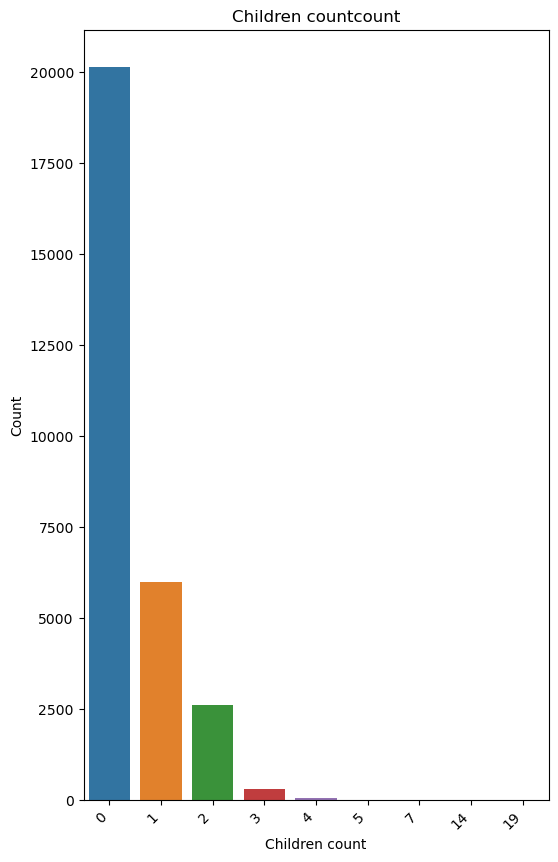

In [ ]:
creat_bar_plot(train_copy, 'Children count')

### Drewlling type

In [ ]:
get_info(train_copy, "Dwelling")

Description:
count                 29165
unique                    6
top       House / apartment
freq                  26059
Name: Dwelling, dtype: object
**************************************************
Object type:
object
Value count:
                     Count  Frequency (%)
House / apartment    26059      89.350249
With parents          1406       4.820847
Municipal apartment    912       3.127036
Rented apartment       453       1.553232
Office apartment       208       0.713184
Co-op apartment        127       0.435453


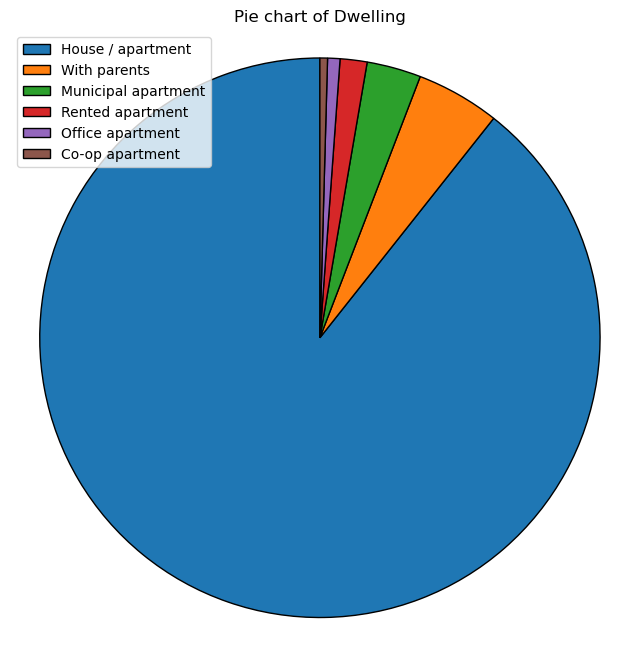

In [ ]:
creat_pie_plot(train_copy, "Dwelling")

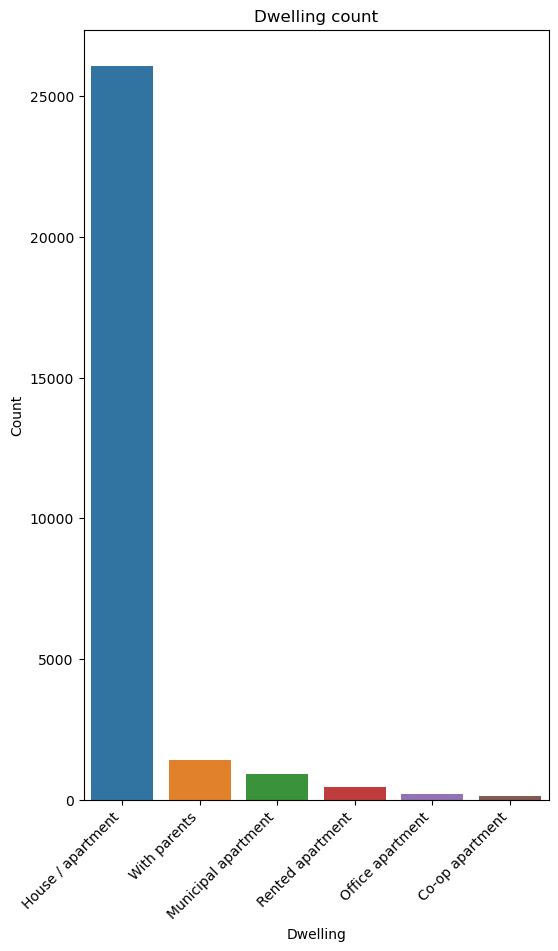

In [ ]:
creat_bar_chart(train_copy, "Dwelling")

### Income

In [ ]:
pd.options.display.float_format = '${:,.2f}'.format
get_info(train_copy, "Income")

Description:
count      $29,165.00
mean      $186,890.39
std       $101,409.64
min        $27,000.00
25%       $121,500.00
50%       $157,500.00
75%       $225,000.00
max     $1,575,000.00
Name: Income, dtype: float64
**************************************************
Object type:
float64
Value count:
             Count  Frequency (%)
$135,000.00   3468         $11.89
$180,000.00   2487          $8.53
$157,500.00   2469          $8.47
$225,000.00   2373          $8.14
$112,500.00   2359          $8.09
...            ...            ...
$164,250.00      1          $0.00
$42,300.00       1          $0.00
$432,000.00      1          $0.00
$145,350.00      1          $0.00
$82,350.00       1          $0.00

[259 rows x 2 columns]


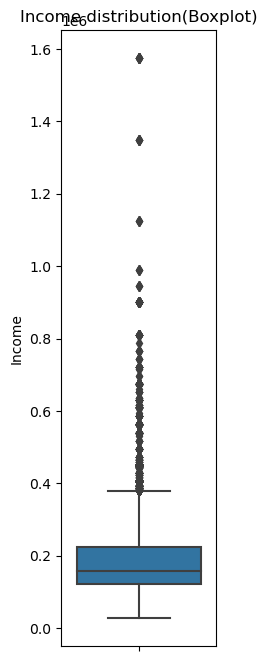

In [ ]:
creat_box_plot(train_copy, "Income")

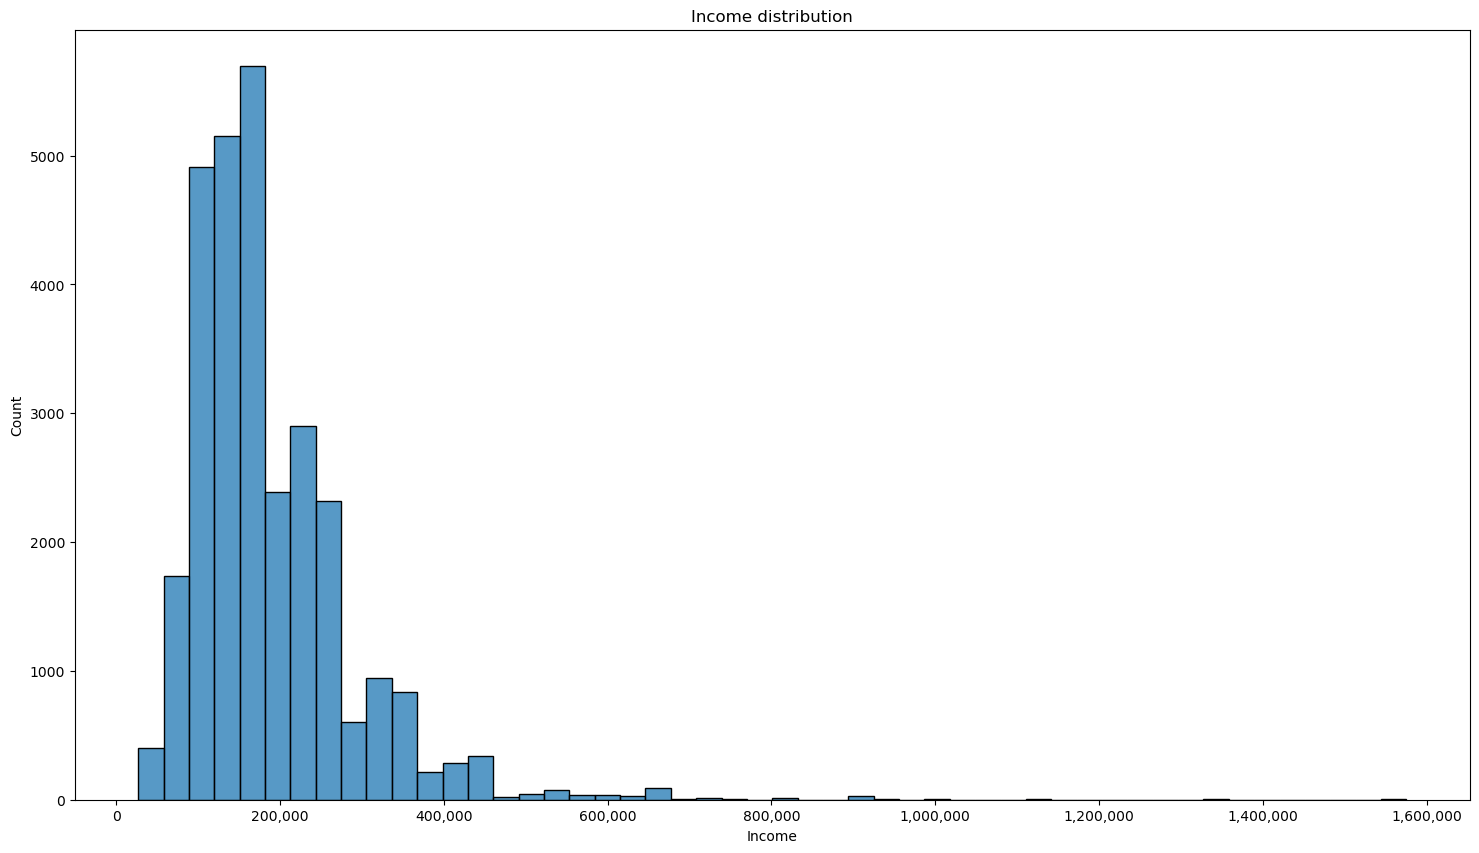

In [ ]:
creat_hist_plot(train_copy, "Income")

### Job title

In [ ]:
get_info(train_copy, "Job title")

Description:
count        20138
unique          18
top       Laborers
freq          5004
Name: Job title, dtype: object
**************************************************
Object type:
object
Value count:
                       Count  Frequency (%)
Laborers                5004      24.848545
Core staff              2866      14.231801
Sales staff             2773      13.769987
Managers                2422      12.027014
Drivers                 1722       8.550998
High skill tech staff   1133       5.626179
Accountants              998       4.955805
Medicine staff           956       4.747244
Cooking staff            521       2.587149
Security staff           464       2.304102
Cleaning staff           425       2.110438
Private service staff    287       1.425166
Low-skill Laborers       138       0.685272
Waiters/barmen staff     127       0.630649
Secretaries              122       0.605820
HR staff                  72       0.357533
Realty agents             60       0.297944
IT s

In [ ]:
job_titile_nn_count = train_copy['Job title'].isna().sum()
job_titile_nn_count

9027

In [ ]:
rows_total_count = train_copy.shape[0]
rows_total_count

29165

In [ ]:
print('The percentage of missing rows is {:.2f} %'.format(job_titile_nn_count * 100 / rows_total_count))

The percentage of missing rows is 30.95 %


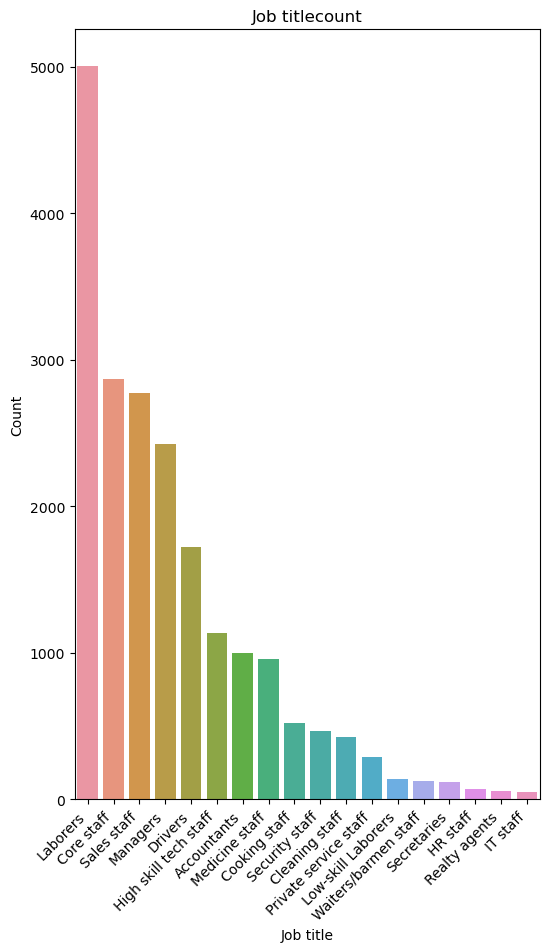

In [ ]:
creat_bar_plot(train_copy, 'Job title')

### Employment status

In [ ]:
get_info(train_copy, 'Employment status')

Description:
count       29165
unique          5
top       Working
freq        15056
Name: Employment status, dtype: object
**************************************************
Object type:
object
Value count:
                      Count  Frequency (%)
Working               15056      51.623521
Commercial associate   6801      23.319047
Pensioner              4920      16.869535
State servant          2381       8.163895
Student                   7       0.024001


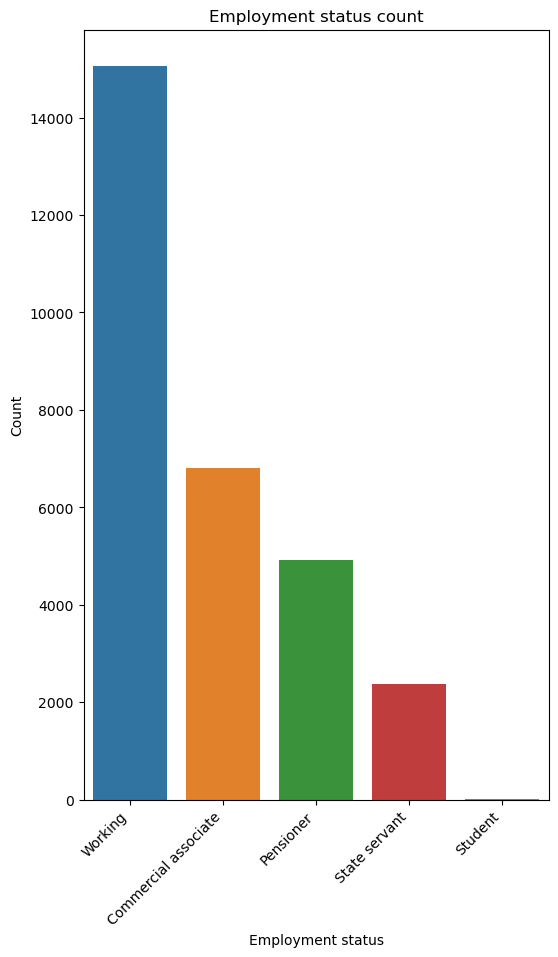

In [ ]:
creat_bar_chart(train_copy, 'Employment status')

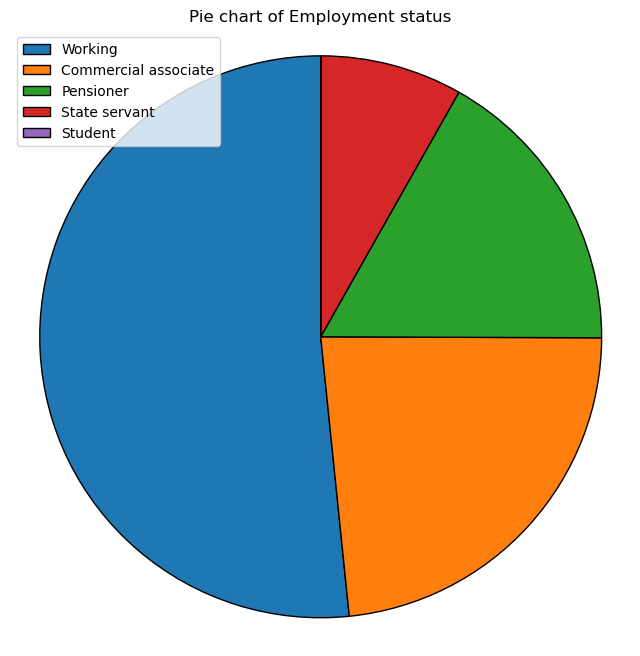

In [ ]:
creat_pie_plot(train_copy, 'Employment status')

### Education level

In [ ]:
get_info(train_copy, 'Education level')

Description:
count                             29165
unique                                5
top       Secondary / secondary special
freq                              19803
Name: Education level, dtype: object
**************************************************
Object type:
object
Value count:
                               Count  Frequency (%)
Secondary / secondary special  19803      67.899880
Higher education                7910      27.121550
Incomplete higher               1129       3.871078
Lower secondary                  298       1.021773
Academic degree                   25       0.085719


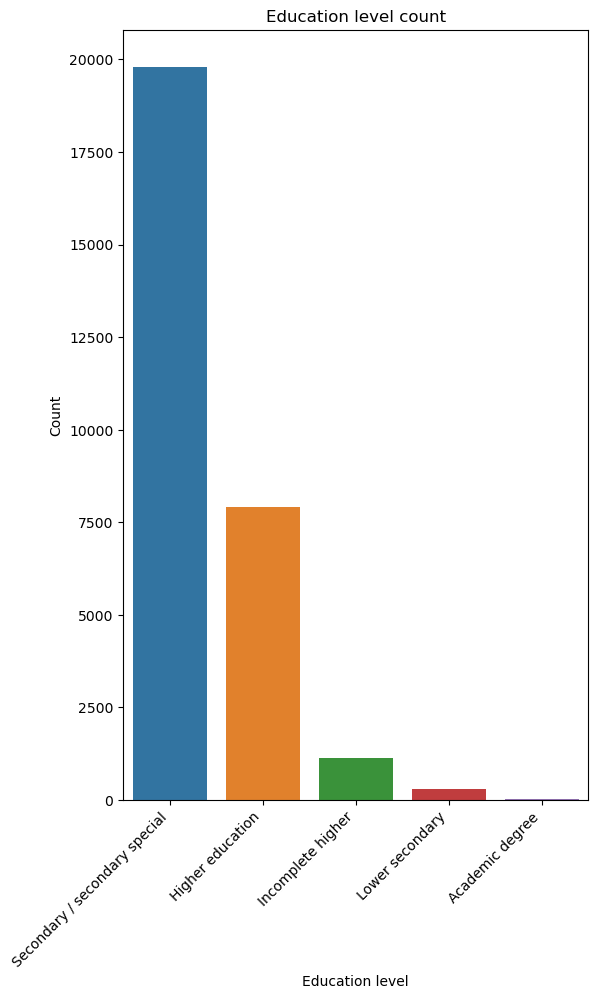

In [ ]:
creat_bar_chart(train_copy, 'Education level')

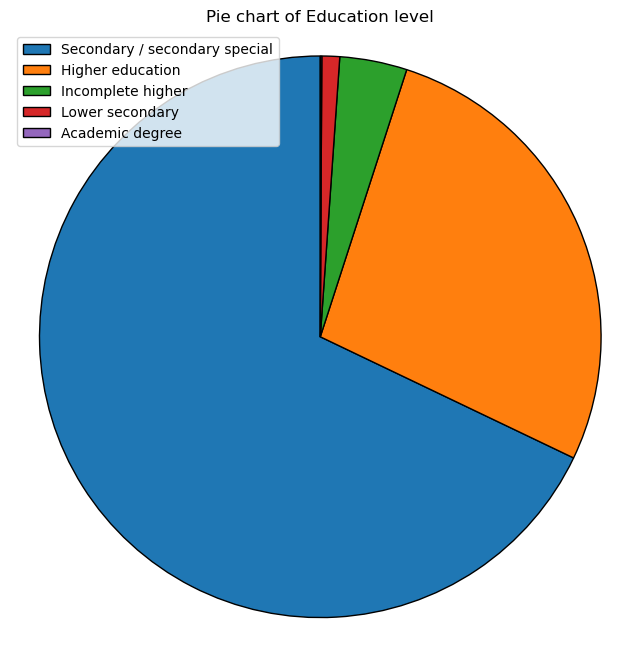

In [ ]:
creat_pie_plot(train_copy, 'Education level')

### Employment length

In [ ]:
get_info(train_copy, 'Employment length')

Description:
count    24257.000000
mean         7.269195
std          6.467791
min          0.046575
25%          2.684932
50%          5.454795
75%          9.605479
max         43.049315
Name: Employment length, dtype: float64
**************************************************
Object type:int64


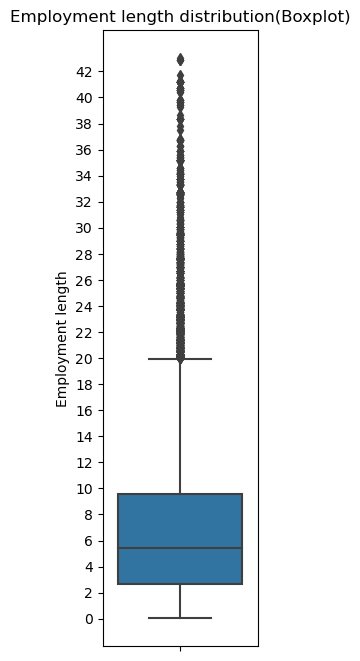

In [ ]:
creat_box_plot(train_copy, 'Employment length')

### Has a car

In [ ]:
get_info(train_copy, 'Has a car')

Description:
count     29165
unique        2
top           N
freq      18128
Name: Has a car, dtype: object
**************************************************
Object type:
object
Value count:
   Count  Frequency (%)
N  18128      62.156695
Y  11037      37.843305


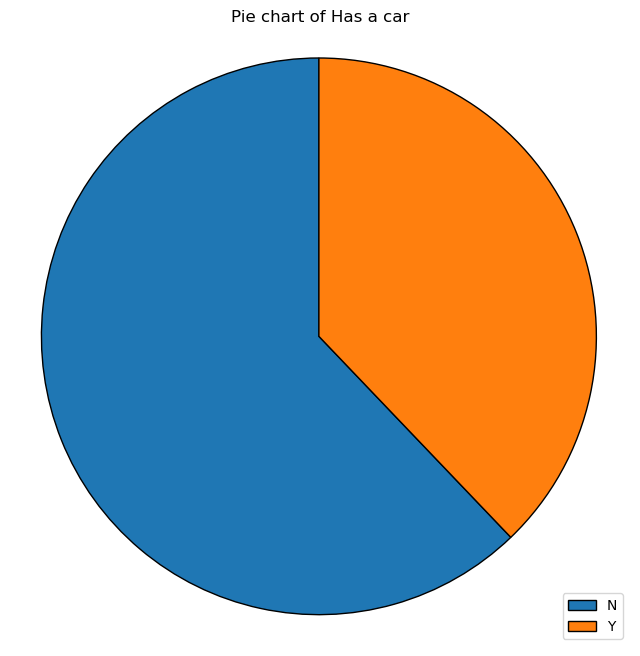

In [ ]:
creat_pie_plot(train_copy,'Has a car')

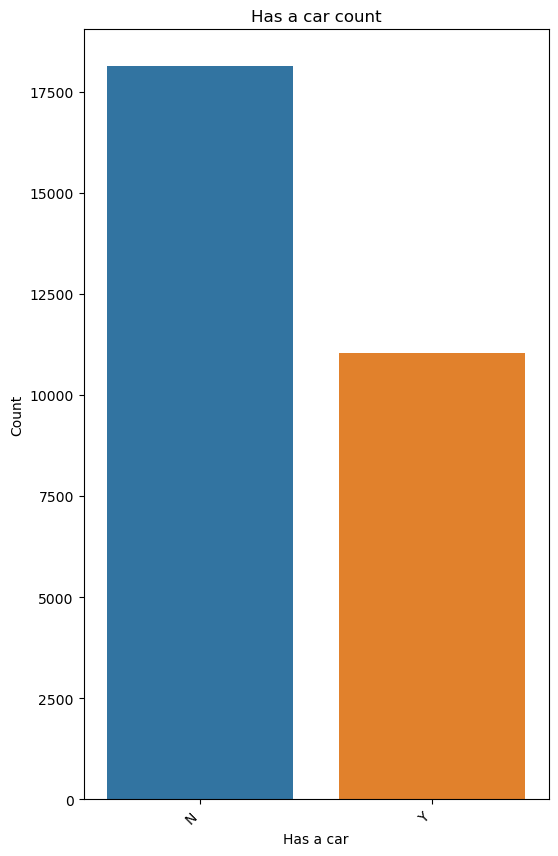

In [ ]:
creat_bar_chart(train_copy, 'Has a car')

### Has a property

In [ ]:
get_info(train_copy, 'Has a property')

Description:
count     29165
unique        2
top           Y
freq      19557
Name: Has a property, dtype: object
**************************************************
Object type:
object
Value count:
   Count  Frequency (%)
Y  19557      67.056403
N   9608      32.943597


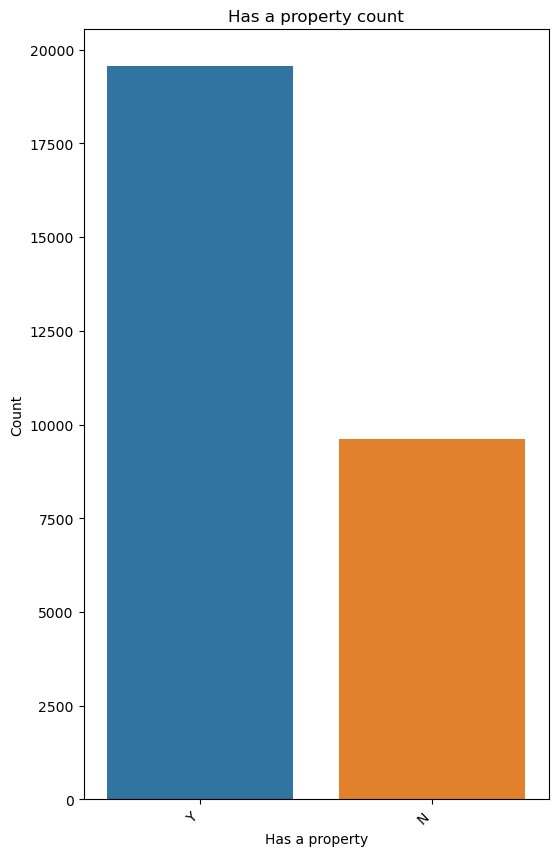

In [ ]:
creat_bar_chart(train_copy, 'Has a property')

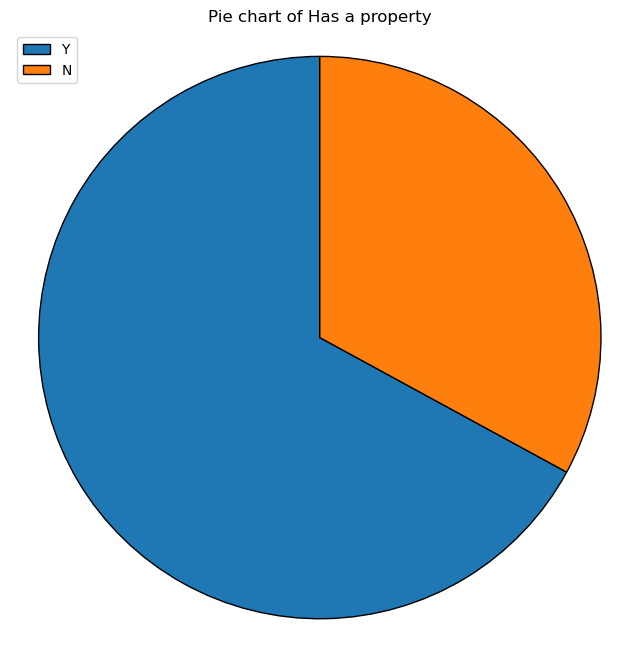

In [ ]:
creat_pie_plot(train_copy, 'Has a property')

### Has a work phone

In [ ]:
get_info(train_copy, 'Has a phone')

Description:
count    29165.000000
mean         0.294977
std          0.456040
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Has a phone, dtype: float64
**************************************************
Object type:
int64
Value count:
   Count  Frequency (%)
0  20562      70.502314
1   8603      29.497686


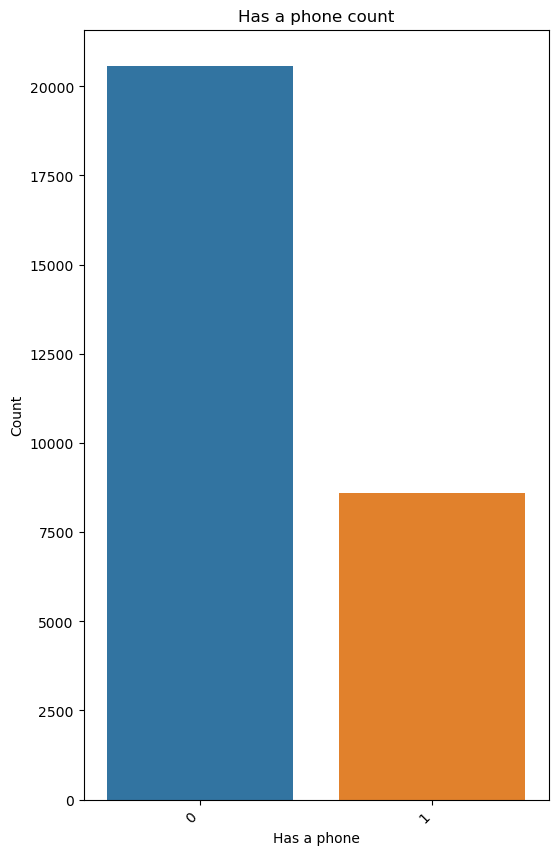

In [ ]:
creat_bar_chart(train_copy, 'Has a phone')

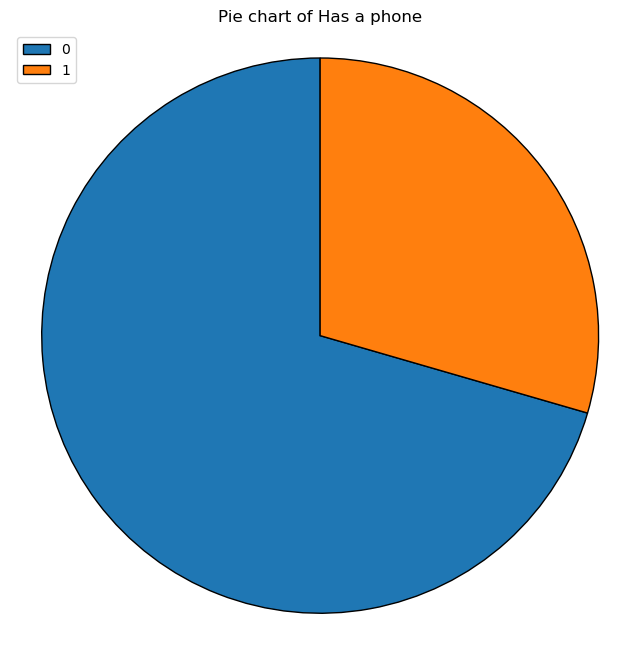

In [ ]:
creat_pie_plot(train_copy, 'Has a phone')

#### Has an email

In [ ]:
get_info(train_copy, 'Has an email')

Description:
count    29165.000000
mean         0.090279
std          0.286587
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Has an email, dtype: float64
**************************************************
Object type:
int64
Value count:
   Count  Frequency (%)
0  26532      90.972056
1   2633       9.027944


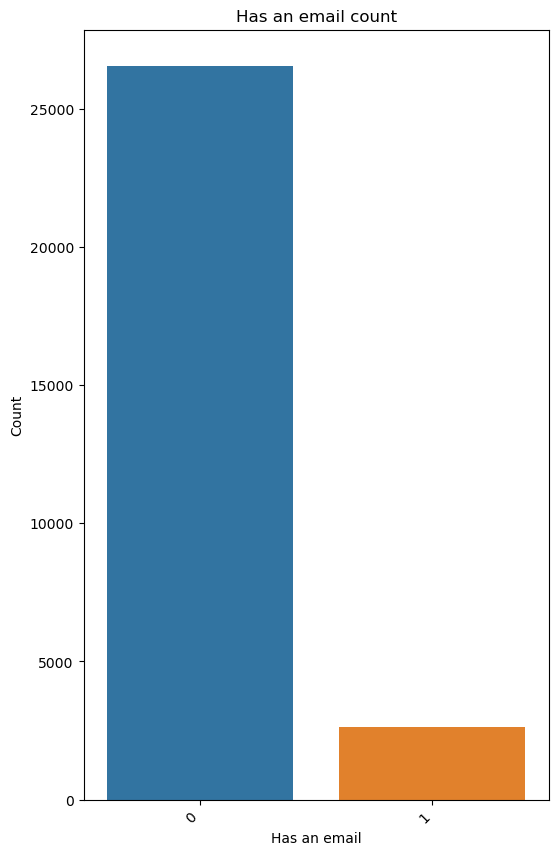

In [ ]:
creat_bar_chart(train_copy, 'Has an email')

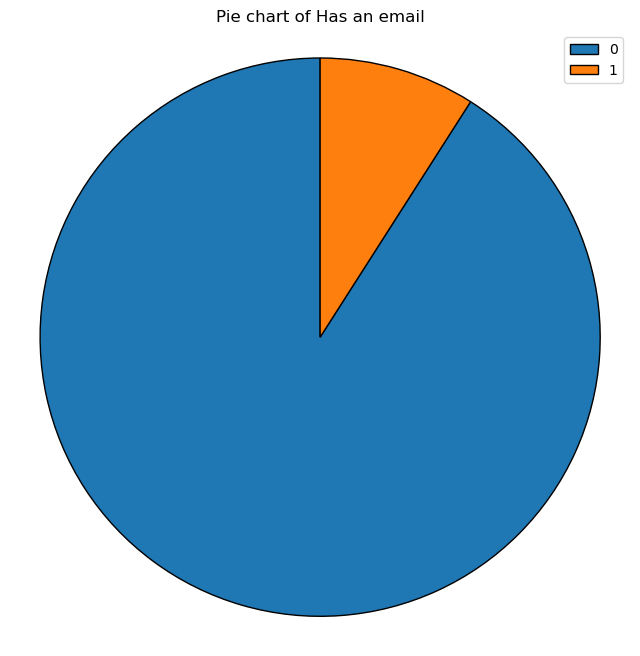

In [ ]:
creat_pie_plot(train_copy, 'Has an email')

### Is high risk

In [ ]:
get_info(train_copy, 'Is high risk')

Description:
count     29165
unique        2
top           0
freq      28666
Name: Is high risk, dtype: int64
**************************************************
Object type:
object
Value count:
   Count  Frequency (%)
0  28666      98.289045
1    499       1.710955


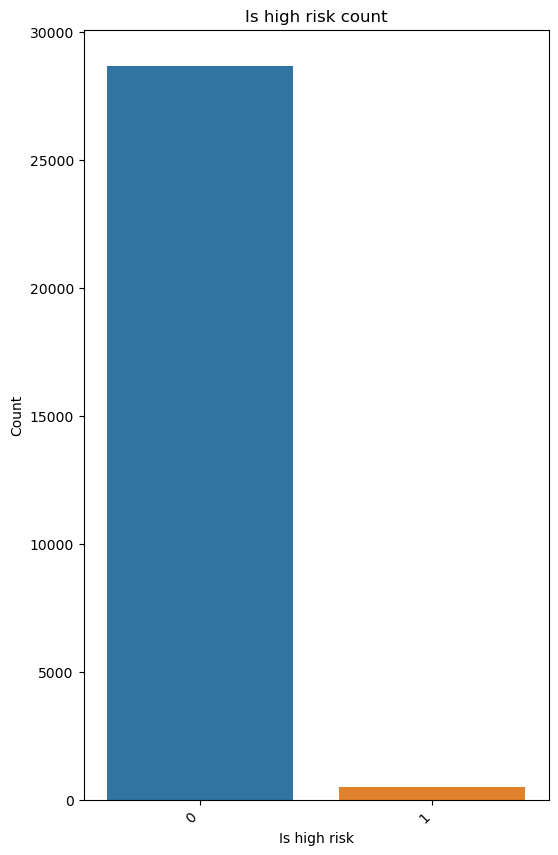

In [ ]:
creat_bar_chart(train_copy, 'Is high risk')

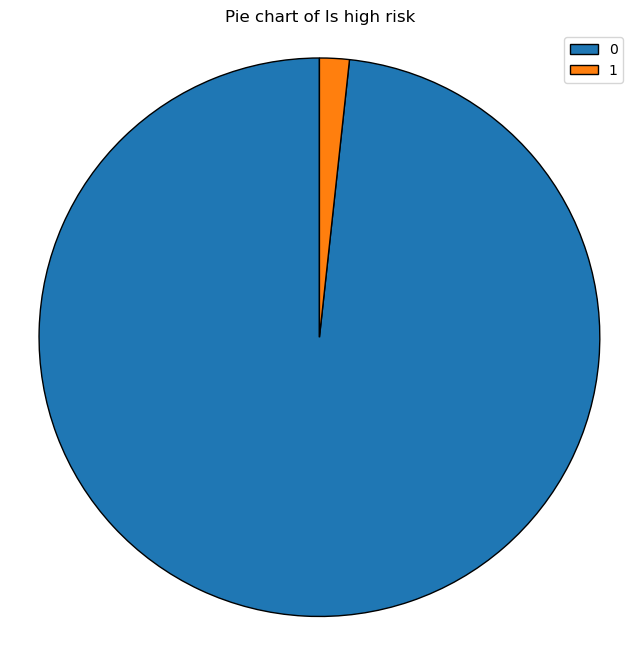

In [ ]:
creat_pie_plot(train_copy, 'Is high risk')

### Chuẩn bị dữ liệu

ID<br>
<li>Xóa thuộc tính </li>
Gender<br>
<li>On hot conding </li>
Age<br>
<li>Min max scalling </li>
<li>Fix skewnes </li>
<li>Abs value and div </li>
Martial status<br>
<li> On hot coding </li>
Children count<br>
<li> Fix outliers </li>
<li> Drop features </li>
Dwelling type<br>
<li> On hot encoding </li>
Income<br>
<li> Remove outliers </li>
<li> Fix skewness </li>
<li> Min max scalling </li>
Job titile<br>
<li>  On hot conding </li>
<li> Fill  missing values </li>
Employment status<br>
<li> Order by enconding </li>
Employment length<br>

#### 3.1 Data selection
##### 3.1.1 Drop features

In [ ]:
class DropFeature(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_drop = ['ID', 'Has a mobile phone', 'Children count', 'Children count', 'Job title', 'Account age']):
        features_to_drop = features_to_drop
    def fit(self, df):
        return self
    def transform(self, df):
        if (set(self.features_to_drop).issubset(df.collums)):
            df.drop(self.features_to_drop, axis=1, inplace=True)
            return df
        else:
            print("One more feature not in data frame")
            return df

Tại sao ta có thể bỏ một số thuộc tính như trên đi?
<li> ID: ID không có tác dụng trong việc dự đoán dữ liệu, nó chỉ giúp ta truy xuất dữ liệu và gộp các bảng lại</li>
<li> Has a mobile phone: Hầu hết ai cũng có một điện thoại nên dữ liệu không giúp ích được gì lắm</li>
<li>Children count: có độ tương quan cao với Family count nên ta chỉ giữ lại một dữ liệu để dự đoán </li>
<li>Job title:Dữ liệu bị thiếu quá nhiều và nghề nghiệp không đa dạng lắm tập trung chủ yếu ở một số nghề </li>
<li> Account age : Thông tin không giúp ích được nhiều để dự báo tín dụng </li>

### 3.2 Feature engineerging
#### 3.2.1 Time conversion

In [ ]:
class TimeConversionHandler(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_days= ['Employment length', 'Age']):
        feat_with_days = feat_with_days
    def fit(self, X, y=None):
        return X
    def transform(self, X, y):
        if (set(self.feat_with_days).issubset(X.collums)):
            #Convert and abs time
            X[['Employment length', 'Age']] = np.abs(X[['Employment length', 'Age']])
            return X
        else:
            print("One of features are not in data frame")
            return X

#### 3.2.2 Retiree handling (in employment length)

In [ ]:
class RetireeHandler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, df):
        return self
    def transform(self, df):
        if 'Employment length' in df.collums:
            # Employment length is 365243 who is retiree
            df_ret_idx = df['Employment length'][df['Employment length'] == 365243].index
            #Change 365243 to 0
            df.loc[df_ret_idx, 'Employment length'] = 0
            return df
        else:
            print("Employment length is not in data frame")
            return df
            

##### 3.2.3 Skeness Handling

In [100]:
class SkenessHandling(BaseEstimator, TransformerMixin):
    def __init__(self, features_with_skeness = ['Income', 'Age']):
        self.features_with_skeness = features_with_skeness
    def fit(self, df):
        return self
    def transform(self, df):
        if (set(self.features_with_skeness).issubset(df.collums)):
            df[self.features_with_skeness] = np.cbrt(df[self.features_with_skeness])
            return df
        else:
            print("One of features is not in dataframe")
            return df

#### 3.2.4 Bining

In [101]:
class BinningToYN(BaseEstimator, TransformerMixin):
    def __init__(self, features_with_binning=['Has a work phone', 'Has a phone', 'Has an email']):
        self.features_with_binning = features_with_binning
    def fit(self, df):
        return self
    def tranform(self, df):
        if (set(self.features_with_binning).issubset(df.collums)):
            for ft in self.features_with_binning:
                df[ft] = df[ft].map({1:'Y', 0:'N'})
            return df
        else:
            print("On of features is not in the dataframe")
            return df

#### 3.2.5 On hot encoding

In [102]:
class OneHotFeatNames(BaseEstimator, TransformerMixin):
    def __init__(self, one_hot_enc = ['Gender', 'Martial status', 'Dwelling','Employment status', 'Has a car', 'Has a property', 'Has a work phone']):
        self.one_hot_enc = one_hot_enc
    def fit(self, df):
        return self
    def transform(self, df):
        
        